In [1]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization, Activation
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
import sys
import os
import numpy as np
import math
import random, time
from pathlib                        import Path
from PIL                            import Image

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt 
import gc
import glob
from skimage                        import img_as_ubyte
from skimage                        import io
import shutil
tf.keras.backend.clear_session()

2025-05-09 15:38:07.443913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746819487.457960   28904 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746819487.462001   28904 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746819487.472645   28904 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746819487.472658   28904 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746819487.472659   28904 computation_placer.cc:177] computation placer alr

### Working with ImageDataGenerator

In [2]:
general_directory ='/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5'

def dataset(directory,batch_size=32):
    data = keras.utils.image_dataset_from_directory(directory,
    labels=None,
    label_mode=None,
    image_size=(128, 256),
    color_mode="grayscale",
    shuffle=False,
    batch_size=batch_size)
    return data

path_1= general_directory + '/geo_masked' + '/train'
path_2= general_directory + '/geo_masked' + '/test'
path_3= general_directory + '/geo_masked' + '/valid'

path_4= general_directory + '/mag_masked' + '/train'
path_5= general_directory + '/mag_masked' + '/test'
path_6= general_directory + '/mag_masked' + '/valid'

path_7= general_directory + '/vx_masked' + '/train'
path_8= general_directory + '/vx_masked' + '/test'
path_9= general_directory + '/vx_masked' + '/valid'

path_10= general_directory + '/vy_masked' + '/train'
path_11= general_directory + '/vy_masked' + '/test'
path_12= general_directory + '/vy_masked' + '/valid'

path_13= general_directory + '/p_masked' + '/train'
path_14= general_directory + '/p_masked' + '/test'
path_15= general_directory + '/p_masked' + '/valid'
    

In [3]:
g_train = dataset(path_1)
g_test  = dataset(path_2)
g_valid = dataset(path_3)
print('******************')
v_train = dataset(path_4)
v_test  = dataset(path_5)
v_valid = dataset(path_6)
print('******************')
vx_train = dataset(path_7)
vx_test  = dataset(path_8)
vx_valid = dataset(path_9)
print('******************')
vy_train = dataset(path_10)
vy_test  = dataset(path_11)
vy_valid = dataset(path_12)
print('******************')
p_train = dataset(path_13)
p_test = dataset(path_14)
p_valid  = dataset(path_15)

Found 14000 files.
Found 2000 files.
Found 4000 files.


I0000 00:00:1746819502.324004   28904 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2117 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


******************
Found 14000 files.
Found 2000 files.
Found 4000 files.
******************
Found 14000 files.
Found 2000 files.
Found 4000 files.
******************
Found 14000 files.
Found 2000 files.
Found 4000 files.
******************
Found 14000 files.
Found 2000 files.
Found 4000 files.


In [4]:
# combination of output datasets
output_train = tf.data.Dataset.zip((v_train,vx_train,vy_train,p_train))
output_test = tf.data.Dataset.zip((v_test,vx_test,vy_test,p_test))
output_valid = tf.data.Dataset.zip((v_valid,vx_valid,vy_valid,p_valid))

# combination of input datasets with output datasets
final_train = tf.data.Dataset.zip((g_train,output_train))
final_test = tf.data.Dataset.zip((g_test,output_test))
final_valid = tf.data.Dataset.zip((g_valid,output_valid))

### Standarize the data

In [5]:
# Standardizing values to be in the [0, 1] range by using tf.keras.layers.Rescaling:
normalization_layer = tf.keras.layers.Rescaling(1./255)

final_train_normalized = final_train.map(lambda x, y: (normalization_layer(x), y))
final_test_normalized = final_test.map(lambda x, y: (normalization_layer(x), y))
final_valid_normalized = final_valid.map(lambda x, y: (normalization_layer(x), y))


### Hiperparámeters

In [6]:
num_epochs = 5
patience=5  # How long to wait after last time validation loss improved
LR=0.001
# Model name
model="U-Net"
plot_name='U-Net_Model.png'
save_in='/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5'
# image dimensions
img_width             =  256   # 739   G:737
img_height            =  128   # 185
channel               =  1

### Architecture

In [9]:

image_input = Input((img_height, img_width, channel))

# Encoder
conv1 = layers.Conv2D(16, 3, activation='relu', padding='same')(image_input)
conv1 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv1)
pool1 = layers.MaxPooling2D((2, 2))(conv1)

conv2 = layers.Conv2D(32, 3, activation='relu', padding='same')(pool1)
conv2 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv2)
pool1 = layers.MaxPooling2D((2, 2))(conv2)

    # Bottleneck
conv3 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
conv3 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv3)

    # Decoder
up4 = layers.UpSampling2D((2, 2))(conv3)
up4 = layers.Concatenate()([up4, conv2])
conv4 = layers.Conv2D(32, 3, activation='relu', padding='same')(up4)
conv4 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv4)

up5 = layers.UpSampling2D((2, 2))(conv4)
up5 = layers.Concatenate()([up5, conv1])
conv5 = layers.Conv2D(16, 3, activation='relu', padding='same')(up5)
conv5 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv5)


# **********************************************************************************************
# Construc  model
# final 1x1 convolutions to get to the correct depth dim (num_classes=4 for v, v-x, v-y, p)
output1 = Conv2D(1,(1,1),activation="relu",name='output_v', padding="same")(conv5)

#output1 = Conv2D(1,(1,1),activation="relu", padding="same")(conv5)
#output1_masked = keras.layers.Multiply(name='output_v')([image_input, output1])

output2 = Conv2D(1,(1,1),activation="relu",name='output_vx', padding="same")(conv5)

#output2 = Conv2D(1,(1,1),activation="relu", padding="same")(conv5)
#output2_masked = keras.layers.Multiply(name='output_vx')([image_input, output2])

output3 = Conv2D(1,(1,1),activation="relu",name='output_vy', padding="same")(conv5)

#output3 = Conv2D(1,(1,1),activation="relu", padding="same")(conv5)
#output3_masked = keras.layers.Multiply(name='output_vy')([image_input, output3])

output4 = Conv2D(1,(1,1),activation="relu",name='output_p', padding="same")(conv5)

#output4 = Conv2D(1,(1,1),activation="relu", padding="same")(conv5)
#output4_masked = keras.layers.Multiply(name='output_p')([image_input, output4])

#model = keras.Model(inputs=image_input, outputs=[output1_masked, output2_masked, output3_masked, output4_masked],name= 'U-Net')
model = keras.Model(inputs=image_input, outputs=[output1, output2, output3, output4],name= 'U-Net')

model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 256,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 256,  │      2,320 │ conv2d_8[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 128,   │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 128,   │      4,640 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 128,   │      9,248 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 64,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 64,    │     36,928 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 64, 128,   │          0 │ conv2d_13[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 128,   │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 96)               │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 128,   │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 128,   │      9,248 │ conv2d_14[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 128, 256,  │          0 │ conv2d_15[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 256,  │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 48)               │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 256,  │      6,928 │ concatenate_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 256,  │      2,320 │ conv2d_16[0][0] 

 Total params: 118,036 (461.08 KB)

 Trainable params: 118,036 (461.08 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(loss=['mse', 'mse', 'mse', 'mse'], optimizer='RMSprop', metrics=["mae","mae","mae","mae"])

print("Starting trainig")

history = model.fit(final_train,epochs=num_epochs,validation_data = final_valid)
   
model.compile(optimizer='RMSprop', 
              loss = {  'output_v': 'mean_squared_error' ,
                        'output_vx': 'mean_squared_error' , 
                        'output_vy': 'mean_squared_error',
                        'output_p': 'mean_squared_error'},
              
              metrics={ 'output_v': ['mae'],
                        'output_vx': ['mae'],
                        'output_vy': ['mae'],
                        'output_p': ['mae'] })

Starting trainig
Epoch 1/5


I0000 00:00:1746819556.768791   28998 service.cc:152] XLA service 0x7f67ec0150e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746819556.768814   28998 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-05-09 15:39:16.884415: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746819557.194040   28998 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-09 15:39:18.750849: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.48 = (f32[32,16,128,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,256]{3,2,1,0} %bitcast.4884, f32[16,1,3,3]{3,2,1,0} %bitcast.4891, f32[16]{0} %bitcast.6018), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

  1/438 ━━━━━━━━━━━━━━━━━━━━ 2:00:31 17s/step - loss: 16619.8418 - output_p_loss: 2400.1230 - output_p_mae: 28.2960 - output_v_loss: 2418.5361 - output_v_mae: 43.0459 - output_vx_loss: 2331.2773 - output_vx_mae: 42.2678 - output_vy_loss: 9469.9053 - output_vy_mae: 94.8263

I0000 00:00:1746819571.345771   28998 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 4772.2119 - output_p_loss: 1318.9109 - output_p_mae: 25.3805 - output_v_loss: 554.1104 - output_v_mae: 16.2873 - output_vx_loss: 539.7748 - output_vx_mae: 16.2454 - output_vy_loss: 2359.4160 - output_vy_mae: 31.6909

2025-05-09 15:40:46.668998: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.48 = (f32[16,16,128,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,128,256]{3,2,1,0} %bitcast.4884, f32[16,1,3,3]{3,2,1,0} %bitcast.4891, f32[16]{0} %bitcast.6018), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_8_1/convolution" source_file="/home/ppgi/miniconda3/envs/newEnviroment/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-09 15:40:46.849642: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 4766.7134 - output_p_loss: 1318.2180 - output_p_mae: 25.3740 - output_v_loss: 553.5222 - output_v_mae: 16.2768 - output_vx_loss: 539.2245 - output_vx_mae: 16.2355 - output_vy_loss: 2355.7466 - output_vy_mae: 31.6552

2025-05-09 15:40:54.837806: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.42 = (f32[32,16,128,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,256]{3,2,1,0} %bitcast.1073, f32[16,1,3,3]{3,2,1,0} %bitcast.1080, f32[16]{0} %bitcast.1082), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_8_1/convolution" source_file="/home/ppgi/miniconda3/envs/newEnviroment/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-09 15:40:55.150249: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:

438/438 ━━━━━━━━━━━━━━━━━━━━ 109s 211ms/step - loss: 4761.2402 - output_p_loss: 1317.5282 - output_p_mae: 25.3675 - output_v_loss: 552.9366 - output_v_mae: 16.2663 - output_vx_loss: 538.6768 - output_vx_mae: 16.2257 - output_vy_loss: 2352.0938 - output_vy_mae: 31.6196 - val_loss: 1315.0389 - val_output_p_loss: 838.9250 - val_output_p_mae: 21.3388 - val_output_v_loss: 171.3072 - val_output_v_mae: 9.2399 - val_output_vx_loss: 175.0444 - val_output_vx_mae: 9.5722 - val_output_vy_loss: 129.7621 - val_output_vy_mae: 9.7658
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 81s 185ms/step - loss: 1294.4072 - output_p_loss: 849.7928 - output_p_mae: 20.3042 - output_v_loss: 170.8891 - output_v_mae: 8.9329 - output_vx_loss: 174.8873 - output_vx_mae: 9.1400 - output_vy_loss: 98.8385 - output_vy_mae: 7.6987 - val_loss: 1355.3013 - val_output_p_loss: 839.1793 - val_output_p_mae: 17.9353 - val_output_v_loss: 157.0170 - val_output_v_mae: 8.3758 - val_output_vx_loss: 177.0315 - val_output_vx_mae: 9.0430 - val_ou

In [11]:
results = model.evaluate(final_test) 
print("Evaluation results:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1157.3202 - output_p_loss: 808.6829 - output_p_mae: 19.7407 - output_v_loss: 145.0628 - output_v_mae: 8.1719 - output_vx_loss: 154.3852 - output_vx_mae: 8.5810 - output_vy_loss: 49.1891 - output_vy_mae: 5.0329

2025-05-09 15:46:41.231351: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.42 = (f32[16,16,128,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,128,256]{3,2,1,0} %bitcast.1073, f32[16,1,3,3]{3,2,1,0} %bitcast.1080, f32[16]{0} %bitcast.1082), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_8_1/convolution" source_file="/home/ppgi/miniconda3/envs/newEnviroment/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-09 15:46:41.413078: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 1156.3345 - output_p_loss: 807.7668 - output_p_mae: 19.7327 - output_v_loss: 145.0013 - output_v_mae: 8.1709 - output_vx_loss: 154.3308 - output_vx_mae: 8.5802 - output_vy_loss: 49.1667 - output_vy_mae: 5.0321
Evaluation results:
loss: 1125.7762
compile_metrics: 143.0923
output_v_loss: 152.6448
output_vx_loss: 48.4698
output_vy_loss: 779.3682
output_p_loss: 19.4840


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


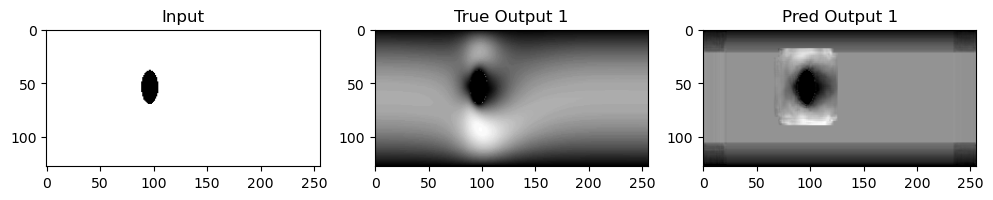

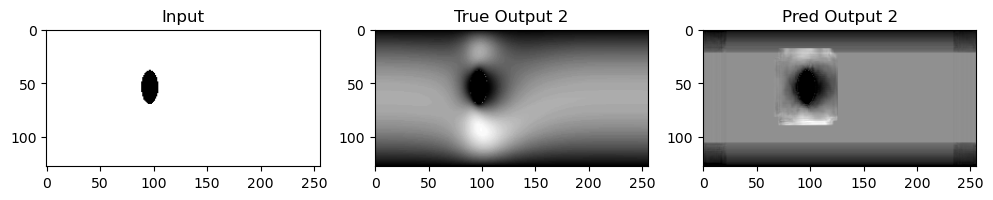

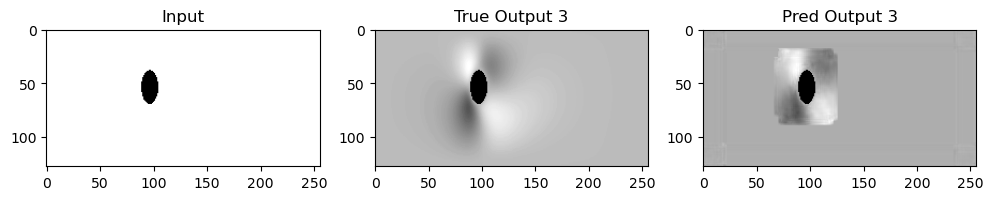

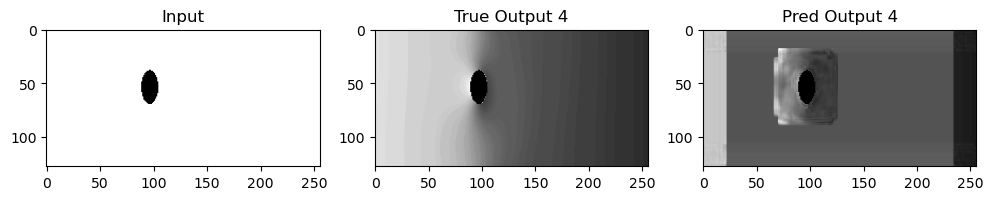

2025-05-09 15:47:01.930693: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
for x_test,y_true in final_test.take(1):
    y_pred = model.predict(x_test)
    for i in range(4):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(x_test[0],cmap='gray')
        axs[0].set_title("Input")

        axs[1].imshow(y_true[i][0],cmap='gray')
        axs[1].set_title(f"True Output {i+1}")

        axs[2].imshow(y_pred[i][0],cmap='gray')
        axs[2].set_title(f"Pred Output {i+1}")
        plt.show()
        